In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [57]:
train_dataset = tfds.load('cifar100',
                          split='train[:80%]',
                          batch_size = 64,
                          shuffle_files = True,
                          as_supervised=True)
isinstance(train_dataset, tf.data.Dataset)

True

In [58]:
train_dataset.element_spec

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

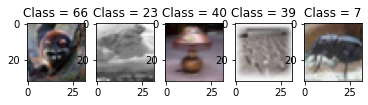

In [60]:
ds = train_dataset.take(1)
fig = plt.figure()
n_images = 5
for i, batch in enumerate(ds):
    x, y = batch
    for j in range(n_images):
        fig.add_subplot(1, n_images, int(j + 1))
        plt.imshow(np.squeeze(x[j]))
        plt.title('Class = {}'.format(np.array(y[j])))

In [61]:
batch = next(train_dataset.as_numpy_iterator())
x, y = batch
inp_shape = x.shape[1:-1]
n_classes = 100
print(x.shape, y.shape)

(64, 32, 32, 3) (64,)


In [62]:
def preprocess_fn(x, y):
    x = tf.cast(x, tf.float32)
    x = x/255
    return (x, y)

In [63]:
train_dataset = train_dataset.map(preprocess_fn)
print(train_dataset)

<MapDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>


In [64]:
valid_dataset = tfds.load('cifar100',
                          split='train[80%:]',
                          batch_size = 32,
                          as_supervised=True)
valid_dataset = valid_dataset.map(preprocess_fn)
print(valid_dataset)

<MapDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int64)>


In [40]:
class Block(tf.keras.Model):
    
    def __init__(self, n_filters, ksize):
        super(Block, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(n_filters,
                                            ksize,
                                            padding='same',
                                            activation='relu',
                                            )
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(0.2)
        self.conv2 = tf.keras.layers.Conv2D(n_filters,
                                            ksize,
                                            padding='same',
                                            activation='relu',
                                            )
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.AvgPool2D(padding='valid')
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool(x)
        return x        

In [65]:
class Model(tf.keras.Model):
    def __init__(self, input_shape, n_classes):
        super(Model, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=input_shape)
        self.block1 = Block(16, 3)
        self.block2 = Block(32, 3)
        self.up1 = tf.keras.layers.UpSampling2D()
        self.cat1 = tf.keras.layers.Concatenate()
        self.cat2 = tf.keras.layers.Concatenate()
        self.block3 = Block(64, 3)
        self.up2 = tf.keras.layers.UpSampling2D()
        self.block4 = Block(128, 3)
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(n_classes)
    
    def call(self, inputs):
        x = self.input_layer(inputs)
        b1 = self.block1(x)
        b2 = self.block2(b1)
        cat1 = self.cat1([b1, self.up1(b2)])
        b3 = self.block3(cat1)
        cat2 = self.cat2([self.up2(b3), cat1])
        b4 = self.block4(cat2)
        x = self.pool(b4)
        y = self.dense(x)
        return y

In [66]:
model = Model(inp_shape, n_classes)
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(x=train_dataset,
          validation_data=valid_dataset,
          epochs=20)

Epoch 1/20
625/625 [==============================] - 11s 17ms/step - loss: 4.1277 - sparse_categorical_accuracy: 0.0862 - val_loss: 3.9327 - val_sparse_categorical_accuracy: 0.1174- sparse_categ
Epoch 2/20
625/625 [==============================] - 8s 13ms/step - loss: 3.7897 - sparse_categorical_accuracy: 0.1355 - val_loss: 3.7674 - val_sparse_categorical_accuracy: 0.1369
Epoch 3/20
625/625 [==============================] - 8s 13ms/step - loss: 3.5868 - sparse_categorical_accuracy: 0.1707 - val_loss: 3.6759 - val_sparse_categorical_accuracy: 0.1492
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 3.4162 - sparse_categorical_accuracy: 0.1994 - val_loss: 3.4808 - val_sparse_categorical_accuracy: 0.1806
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 3.2623 - sparse_categorical_accuracy: 0.2264 - val_loss: 3.2743 - val_sparse_categorical_accuracy: 0.2203
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 3.123

In [67]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 32, 32)]          0         
_________________________________________________________________
block_64 (Block)             multiple                  2896      
_________________________________________________________________
block_65 (Block)             multiple                  14144     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 multiple                  0         
_________________________________________________________________
concatenate_10 (Concatenate) multiple                  0         
_________________________________________________________________
concatenate_11 (Concatenate) multiple                  0         
_________________________________________________________________
block_66 (Block)             multiple                  651